# Face Recognition

## Data Preparation

### Mount Drive

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Newton AI-Face Recognition Project/2. Model Experiments/ResNet/ResNet-50'

/content/drive/.shortcut-targets-by-id/1sY4g5kGDpNZKHuLnFwR9zgjHpx9t274-/Newton AI-Face Recognition Project/2. Model Experiments/ResNet/ResNet-50


In [3]:
directory = '/content/drive/MyDrive/Newton AI-Face Recognition Project/2. Model Experiments/ResNet/ResNet-50'

In [4]:
data_path = '/content/drive/MyDrive/Newton AI-Face Recognition Project/Dataset/SPLIT'

### Load, Split and Transform Data

In [5]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
dataset = ImageFolder(data_path)
classes = dataset.classes
print(classes)

['Female', 'Male']


In [7]:
class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [8]:
test_ratio = 0.25
total_samples = len(dataset)
test_samples = int(test_ratio * total_samples)
train_samples = total_samples - test_samples

In [9]:
trainset, testset = random_split(dataset, [train_samples, test_samples])

In [10]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [11]:
train_data = MyDataset(trainset, transform=train_transform)
test_data = MyDataset(testset, transform=test_transform)

In [12]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

## Data Visualization

In [13]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [14]:
data_iterator = iter(train_loader)
images, labels = next(data_iterator)

In [15]:
def show(img, labels):
  str_labels = [classes[i] for i in labels]
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img * std) + mean
  plt.imshow(img)
  plt.title(' '.join(str_labels))
  plt.show()

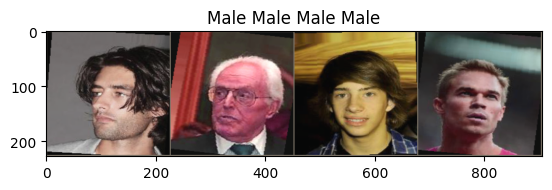

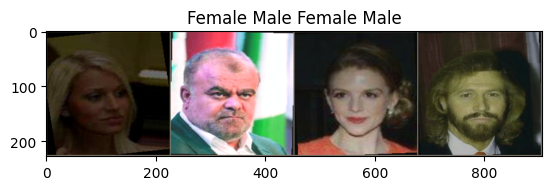

In [16]:
show(make_grid(images[:4]), labels[:4])
show(make_grid(images[4:8]), labels[4:8])

## Build Model Architecture

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights

In [18]:
def build_model():
  model = resnet50(ResNet50_Weights.DEFAULT)
  model.fc = nn.Linear(model.fc.in_features, len(classes))
  return model

In [19]:
model = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 73.5MB/s]


## Training Model (With GPU)

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda:0


In [21]:
def train_engine(train_loader, test_loader, model, criterion, optimizer, 
                 checkpoint_path, num_epochs=30, early_stopping_patience=5, device="cpu"):
    """
    Train engine function for PyTorch models with checkpointing and early stopping callbacks.

    Args:
    - train_loader (DataLoader): DataLoader for the training set.
    - test_loader (DataLoader): DataLoader for the test set.
    - model (nn.Module): PyTorch model to be trained.
    - criterion (nn.Module): PyTorch loss function.
    - optimizer (nn.Module): PyTorch optimizer.
    - checkpoint_path (str): Path to save the model checkpoints.
    - early_stopping_patience (int): Number of epochs to wait for the validation loss to improve before stopping early.
    - device (str): Device to use for training ("cpu" or "cuda").

    Returns:
    - best_epoch (int): The epoch with the best validation loss.
    - best_val_loss (float): The best validation loss achieved during training.
    """

    # Move the model and loss function to the specified device
    model.to(device)
    criterion.to(device)

    # Initialize variables for early stopping
    best_val_loss = float("inf")
    val_losses = []
    no_improvement_epochs = 0

    # Train the model for a fixed number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for inputs, labels in train_loader:
            # Move the inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            for inputs, labels in test_loader:
                # Move the inputs and labels to the specified device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate the loss
                total_loss += loss.item()

            # Compute the average validation loss
            avg_val_loss = total_loss / len(test_loader)
            val_losses.append(avg_val_loss)

            # Print the current epoch and validation loss
            print(f"Epoch {epoch+1}/{num_epochs}: Validation loss = {avg_val_loss:.4f}")

            # Checkpoint the model if the validation loss has improved
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improvement_epochs = 0
                torch.save(model.state_dict(), checkpoint_path)
                print('Validation Loss Improved. Saving Best Model.')
            else:
                no_improvement_epochs += 1

            # Stop early if the validation loss has not improved for a fixed number of epochs
            if no_improvement_epochs >= early_stopping_patience:
                print(f"Validation loss has not improved for {early_stopping_patience} epochs. Stopping early.")
                return val_losses, best_val_loss

    return val_losses, best_val_loss


In [22]:
val_losses, best_val_loss = train_engine(train_loader, test_loader, model, criterion, optimizer, 
                                         'model.pth', device=device)

Epoch 1/30: Validation loss = 0.3253
Validation Loss Improved. Saving Best Model.
Epoch 2/30: Validation loss = 0.1305
Validation Loss Improved. Saving Best Model.
Epoch 3/30: Validation loss = 0.1685
Epoch 4/30: Validation loss = 0.1030
Validation Loss Improved. Saving Best Model.
Epoch 5/30: Validation loss = 0.0880
Validation Loss Improved. Saving Best Model.
Epoch 6/30: Validation loss = 0.0909
Epoch 7/30: Validation loss = 0.1022
Epoch 8/30: Validation loss = 0.1009
Epoch 9/30: Validation loss = 0.0953
Epoch 10/30: Validation loss = 0.0798
Validation Loss Improved. Saving Best Model.
Epoch 11/30: Validation loss = 0.0878
Epoch 12/30: Validation loss = 0.1034
Epoch 13/30: Validation loss = 0.1115
Epoch 14/30: Validation loss = 0.0971
Epoch 15/30: Validation loss = 0.1051
Validation loss has not improved for 5 epochs. Stopping early.


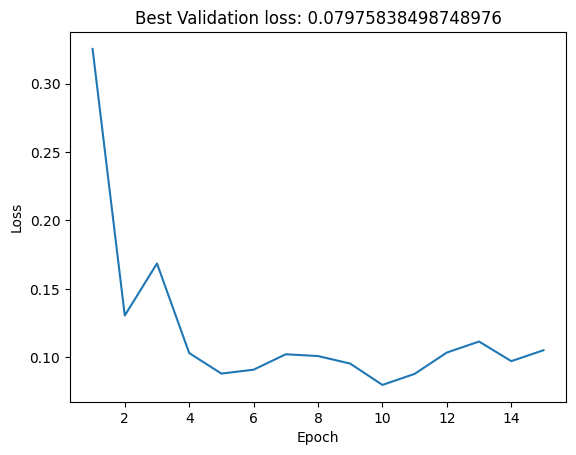

In [23]:
plt.plot(range(1, len(val_losses)+1), val_losses)
plt.title(f'Best Validation loss: {best_val_loss}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Model Evaluation

In [24]:
import torch.nn.functional as F

In [25]:
model = build_model()
model.load_state_dict(torch.load('model_50.pth'))

<All keys matched successfully>

In [26]:
data_iterator = iter(test_loader)
images, labels = next(data_iterator)

In [27]:
outputs = model(images)
_, predictions = torch.max(outputs, 1)

In [28]:
def show(img, labels, preds):
  str_labels = [classes[i] for i in labels]
  str_preds = [classes[j] for j in preds]
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img * std) + mean
  plt.imshow(img)
  plt.show()
  print('Ground Truth: ', ' '.join(str_labels))
  print('Predictions: ', ' '.join(str_preds))

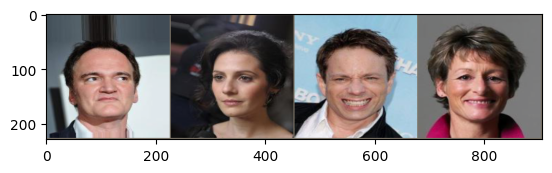

Ground Truth:  Male Female Male Female
Predictions:  Male Female Male Female


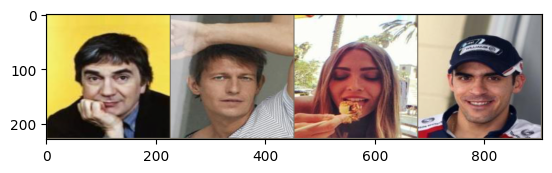

Ground Truth:  Male Male Female Male
Predictions:  Male Male Female Male


In [29]:
show(make_grid(images[:4]), labels[:4], predictions[:4])
show(make_grid(images[4:8]), labels[4:8], predictions[4:8])

In [30]:
correct_pred = {name: 0 for name in classes}
total_pred = {name: 0 for name in classes}

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

    for label, pred in zip(labels, predictions):
      if label == pred:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

for class_name, correct_count in correct_pred.items():
  class_acc = (correct_count/total_pred[class_name]) * 100
  print(f'[Accuracy for class: {class_name}]: {round(class_acc, 2)}')

total_correct = 0
for count in correct_pred.values():
  total_correct += count
test_acc = (total_correct/len(test_data)) * 100
print(f'Testing Accuracy: {round(test_acc, 2)} %')

[Accuracy for class: Female]: 97.16
[Accuracy for class: Male]: 96.68
Testing Accuracy: 96.96 %


In [31]:
import time

In [32]:
#ngetest cpu
for i in range(5):
  t0 = time.time() # return jumlah detik dalam hari itu 9*60*2+14*60+10+5*10^(-3) H*60^2 + M*60 + S + MS*10^(-3)
  out = images[1].unsqueeze(0).cuda()
t1 = time.time()
print(f"inference on CPU: {t1-t0:.5f}s")


inference on CPU: 0.00039s


In [33]:
#ngetest gpu
model = model.cuda()
test_input = images[1].unsqueeze(0).cuda()

for i in range(5):
  t0 = time.time() # return jumlah detik dalam hari itu 9*60*2+14*60+10+5*10^(-3) H*60^2 + M*60 + S + MS*10^(-3)
  out = model(test_input)
t1 = time.time()
print(f"inference on GPU: {t1-t0:.5f}s")

inference on GPU: 0.02241s
